# Mini Project T2 - Team 1 - Image Acquisition for Project A

## Setup

In [1]:
import sys
# Python 3.7 is required
assert sys.version_info >= (3, 7)

import cv2 as cv
import numpy as np

# Make sure that OpenCV optimization is enabled
if not cv.useOptimized():
    cv.setUseOptimized(True)
    
cv.useOptimized()

True

## Load and Display Random Images 

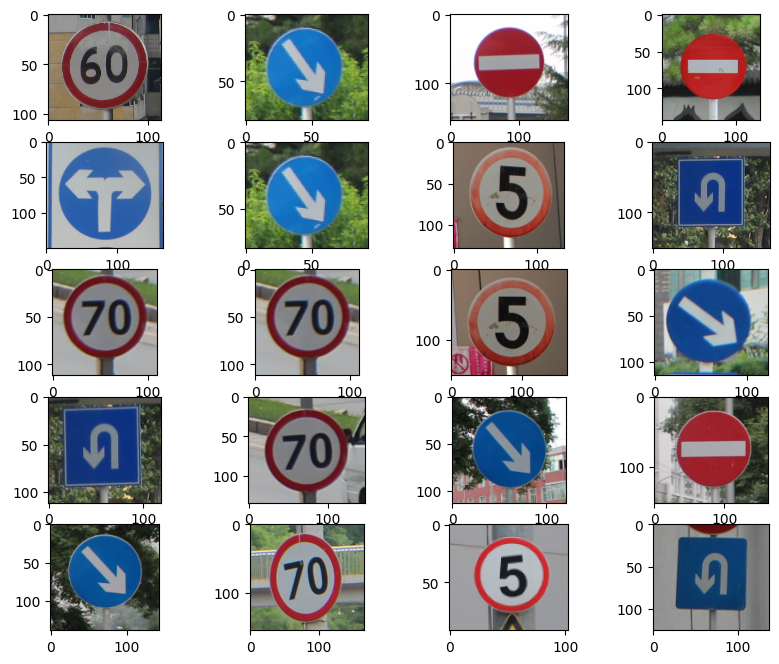

In [2]:
import matplotlib.pyplot as plt
import os
import numpy
import cv2 as cv
import numpy as np

# "images/" is the local file path where all the 4170 images located at
files = np.random.choice(os.listdir("images/"), size=20, replace=True)
img_dir = "images/"

plt.figure(figsize=(10, 8))
for i, img_file in enumerate(files):
    img = cv.imread(img_dir + img_file)
    
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.subplot(5, 4, i+1)
    plt.imshow(img_rgb)
    
plt.show()

In [3]:
def preprocess_image(img, width, height, blur_ksize=(5, 5)):
    # Resize the image
    resized_img = cv.resize(img, (width, height))
    
    # Denoise the image using Gaussian blur
    denoised_img = cv.GaussianBlur(resized_img, blur_ksize, 0)
    
    # Convert to grayscale
    gray_img = cv.cvtColor(denoised_img, cv.COLOR_BGR2GRAY)
    
    # Convert grayscale to BGR to apply contrast enhancement
    gray_img_bgr = cv.cvtColor(gray_img, cv.COLOR_GRAY2BGR)
    
    # Contrast enhancement
    img_lab = cv.cvtColor(gray_img_bgr, cv.COLOR_BGR2Lab)
    L, a, b = cv.split(img_lab)
    L = cv.equalizeHist(L)
    img_lab_merge = cv.merge((L, a, b))
    enhanced_img = cv.cvtColor(img_lab_merge, cv.COLOR_Lab2BGR)
    
    return enhanced_img

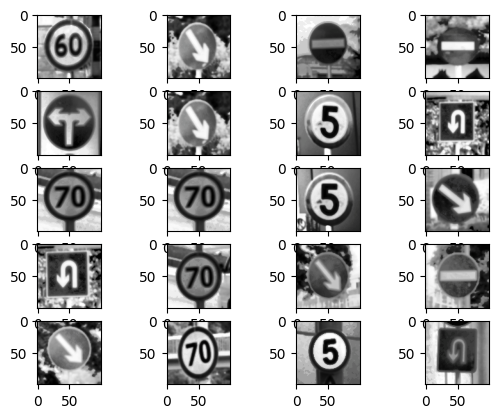

In [4]:
for i, img_file in enumerate(files):
    img = cv.imread(img_dir + img_file)
    
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_rgb =  preprocess_image(img,100,100)
    plt.subplot(5, 4, i+1)
    plt.imshow(img_rgb)

In [5]:
lower_bounds = [
    (0, 40, 50),   # lower bound for red range 1
    (165, 40, 50), # lower bound for red range 2
    (90, 40, 50),  # lower bound for blue
    (20, 40, 50),  # lower bound for yellow
    (0, 0, 0)      # lower bound for black
]

upper_bounds = [
    (10, 255, 210), # upper bound for red range 1
    (179, 255, 210),# upper bound for red range 2
    (120, 255, 210),# upper bound for blue
    (35, 255, 210), # upper bound for yellow
    (179, 255, 5)   # upper bound for black
]

# Color-based segmentation function
def color_seg(img, kernel_size=None):
    """
    Perform color-based segmentation to detect specific colors in an image.
    
    Args:
    img: Input image in BGR format.
    lower_bounds: List of lower bounds for the HSV color ranges.
    upper_bounds: List of upper bounds for the HSV color ranges.
    kernel_size: Size of the kernel for morphological operations (default is (3, 3)).
    
    Returns:
    mask_combined: Combined binary mask of the segmented areas.
    """
    # Convert the image from BGR to HSV color space
    hsv_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    
    # Initialize the combined mask
    mask_combined = np.zeros(hsv_img.shape[:2], dtype=np.uint8)
    
    # Iterate through each color range and create a mask
    for lower, upper in zip(lower_bounds, upper_bounds):
        mask = cv.inRange(hsv_img, lower, upper)
        mask_combined |= mask  # Combine masks using bitwise OR
    
    # Define the kernel for morphological operations
    if kernel_size is not None:
        kernel = np.ones(kernel_size, np.uint8)
    else:
        kernel = np.ones((3, 3), np.uint8)
        
    # Apply morphological operations to remove noise and fill gaps
    mask_combined = cv.morphologyEx(mask_combined, cv.MORPH_OPEN, kernel)
    mask_combined = cv.morphologyEx(mask_combined, cv.MORPH_CLOSE, kernel)
    
    return mask_combined

In [6]:
# rectangle detection (using Douglas-Peuker algorithm)
def rect_detect(cnts, coef=0.1):
    """
    Identifies and returns the largest rectangular contour from a list of contours
    
    Args:
    cnts: List of contours detected in an image
    coef: Coefficient to determine the approximation accuracy 
            for contour simplification. Lower values result in 
            more detailed approximations (default is 0.1)
            
    Return:
    numpy.ndarray or None: The largest rectangular contour if found, otherwise None.
    """
    rect_lists = []
    for cnt in cnts:
        if cnt is not None and len(cnt) > 0:
            perimeter = cv.arcLength(cnt, True)
            approx = cv.approxPolyDP(cnt, coef*perimeter, True)
            if len(approx) == 4:
                rect_lists.append(cnt)
    return max(rect_lists, key=lambda c: cv.contourArea(c)) if rect_lists else None
    
# circle detection (using Hough Transform)
hough_circle_parameters = {
    "dp": 1,
    "minDist": 150,
    "param1": 200, 
    "param2": 15,  
    "minRadius": 10,
    "maxRadius": 100
}
def circle_detect(img, hough_dict):
    """
    Detects circles in a grayscale image using the Hough Circle Transform method.
    
    Args:
    img: Grayscale image in which circles are to be detected.
    hough_dict: hough_circle_transform parameters

    Returns:
    numpy.ndarray or None: The largest circle contour if found, otherwise None.
    """
    mask_circle = np.zeros_like(img)
    circles_detected = cv.HoughCircles(img, 
                              cv.HOUGH_GRADIENT, 
                              hough_dict["dp"], 
                              hough_dict["minDist"], 
                              param1=hough_dict["param1"], 
                              param2=hough_dict["param2"],
                              minRadius=hough_dict["minRadius"], 
                              maxRadius=hough_dict["maxRadius"])
    if circles_detected is not None:
        largest_circle = max(circles_detected[0], key=lambda x: x[2])
        center_x, center_y, radius = largest_circle
        cv.circle(mask_circle, (int(center_x), int(center_y)), int(radius), 255)
        contours_circle, _ = cv.findContours(mask_circle, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        return max(contours_circle, key=lambda c: cv.contourArea(c)) if contours_circle else None
    return None

In [7]:
# combine the results of 2 shape detectors
def combine_shapes(rect_cnt, circle_cnt, cnt):
    """
    Combines and selects the most significant contour from detected rectangles, circles,
    and any additional contours based on their areas.

    Args:
    rect_cnt: The largest rectangular contour detected.
    circle_cnt: The largest circular contour detected.
    cnt: List of additional contours detected in the image.

    Returns:
    numpy.ndarray: The most significant contour (either rectangle, circle, or another contour)
                   based on the largest area. Returns an empty array if no contours are found.
    
    """
    if rect_cnt is not None and circle_cnt is not None:
        if cv.contourArea(circle_cnt) > cv.contourArea(rect_cnt):
            return circle_cnt
        else:
            return rect_cnt
    elif circle_cnt is not None:
        return circle_cnt
    elif rect_cnt is not None:
        return rect_cnt
    elif cnt:
        return max(cnt, key=lambda c: cv.contourArea(c))
    return np.array([])

In [8]:
def combine_edge_color(edges_output, color_output, verbose=False):
    """
    Integrate the results of edge detection and color-based segmentation,
    followed by shape detection to determine the most significant contours.

    Args:
    edges_output: Output from edge detection, should be a list of contours.
    color_output: Output from color-based segmentation, should be a list of contours.
    verbose: Boolean flag for verbosity in output (default is False).

    Returns:
    np.ndarray: The most significant contours from the combined results.
    """
    # Ensure inputs are valid contour lists
    if not isinstance(edges_output, list):
        edges_output = list(edges_output)
        
    if not isinstance(color_output, list):
        color_output = list(color_output)

    if verbose:
        print(f"Contours from edge detection: {len(edges_output)}")
        print(f"Contours from color segmentation: {len(color_output)}")
    
    # Handle cases where both outputs are empty
    if not edges_output and not color_output:
        return np.array([])

    # Sort contours by area in descending order
    edges_output = sorted(edges_output, key=cv.contourArea, reverse=True)
    color_output = sorted(color_output, key=cv.contourArea, reverse=True)

    # Handle cases where only one output is available
    if not edges_output:
        return np.array(color_output)
    
    if not color_output:
        return np.array(edges_output)

    # Combine masks logically if needed (optional)
    # combined_mask = cv.bitwise_or(edges_mask, color_mask)

    # Compare contours based on area and return the more significant one
    if cv.contourArea(edges_output[0]) > cv.contourArea(color_output[0]):
        return np.array(edges_output)
    else:
        return np.array(color_output)